#Project B78 - Model Selection Methods 
In this project, I explored two methods used for model selection: Best Subsets and Forward Stepwise. I chose 'Electricity' data set for analysis. The goal is to model cost function of producing electricity given seven predictors. Used the two methods respectively to output subsets of variabales to be used in the final model based on criterion specified by these two methods. Also, in the last step, I used cross validation approach to predict the performance of final model.

In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#load the data set 'Electricity', the first column of the data set is index column 
elec = pd.read_csv('/content/sample_data/Electricity.csv', index_col = [0])
#dimension of the data frame
elec.shape
#rename data frame columns of predictor variables 
elec = elec.rename({'cost':'Cost','q': 'TotalOutput', 'pl':'WageRate', 'sl': 'CostSharePerLabor', 'pk':'CapitalPriceIndex', 
                'sk':'CostShareForCapital', 'pf':'FuelPrice', 'sf':'CostShareForFuel'}, axis = 1)
#only use first 154 observations for analysis
elec = elec.iloc[0:154,:]
elec

,Cost,TotalOutput,WageRate,CostSharePerLabor,CapitalPriceIndex,CostShareForCapital,FuelPrice,CostShareForFuel
1,0.2130,8.0,6869.47,0.3291,64.945,0.4197,18.000,0.2512
2,3.0427,869.0,8372.96,0.1030,68.227,0.2913,21.067,0.6057
3,9.4059,1412.0,7960.90,0.0891,40.692,0.1567,41.530,0.7542
4,0.7606,65.0,8971.89,0.2802,41.243,0.1282,28.539,0.5916
5,2.2587,295.0,8218.40,0.1772,71.940,0.1623,39.200,0.6606
...,...,...,...,...,...,...,...,...
150,12.3243,2816.0,13044.00,0.0893,58.860,0.2946,30.590,0.6161
151,0.3158,16.3,7727.77,0.1700,38.106,0.1767,33.460,0.6533
152,10.5287,1823.0,10029.47,0.0761,69.760,0.1724,36.000,0.7515
153,22.1998,4800.0,12742.47,0.1239,33.840,0.1678,32.250,0.7083


#Preprocessing and preparing data 
1. The data set 'Eletricity' has seven numerical predictor variables and cost as the response variable
2. Perform checks/diagnostics 

In [ ]:
elec.describe()

,Cost,TotalOutput,WageRate,CostSharePerLabor,CapitalPriceIndex,CostShareForCapital,FuelPrice,CostShareForFuel
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,53.966669,10602.999351,8015.996039,0.138465,71.299266,0.227201,30.599111,0.631993
std,87.978512,15330.444935,1396.953852,0.054781,12.104222,0.060567,7.901856,0.083621
min,0.130400,4.000000,5063.490000,0.045900,31.725000,0.098100,9.000000,0.243500
25%,10.367375,2005.750000,6978.655000,0.099725,67.572500,0.192550,24.305450,0.590100
50%,25.545400,5673.500000,7903.915000,0.122200,74.120000,0.218600,30.617300,0.645000
75%,55.315900,12365.750000,8855.230000,0.168575,78.959750,0.252775,35.991275,0.685950
max,737.408800,115500.000000,13044.000000,0.329100,92.650000,0.457100,51.463000,0.813600


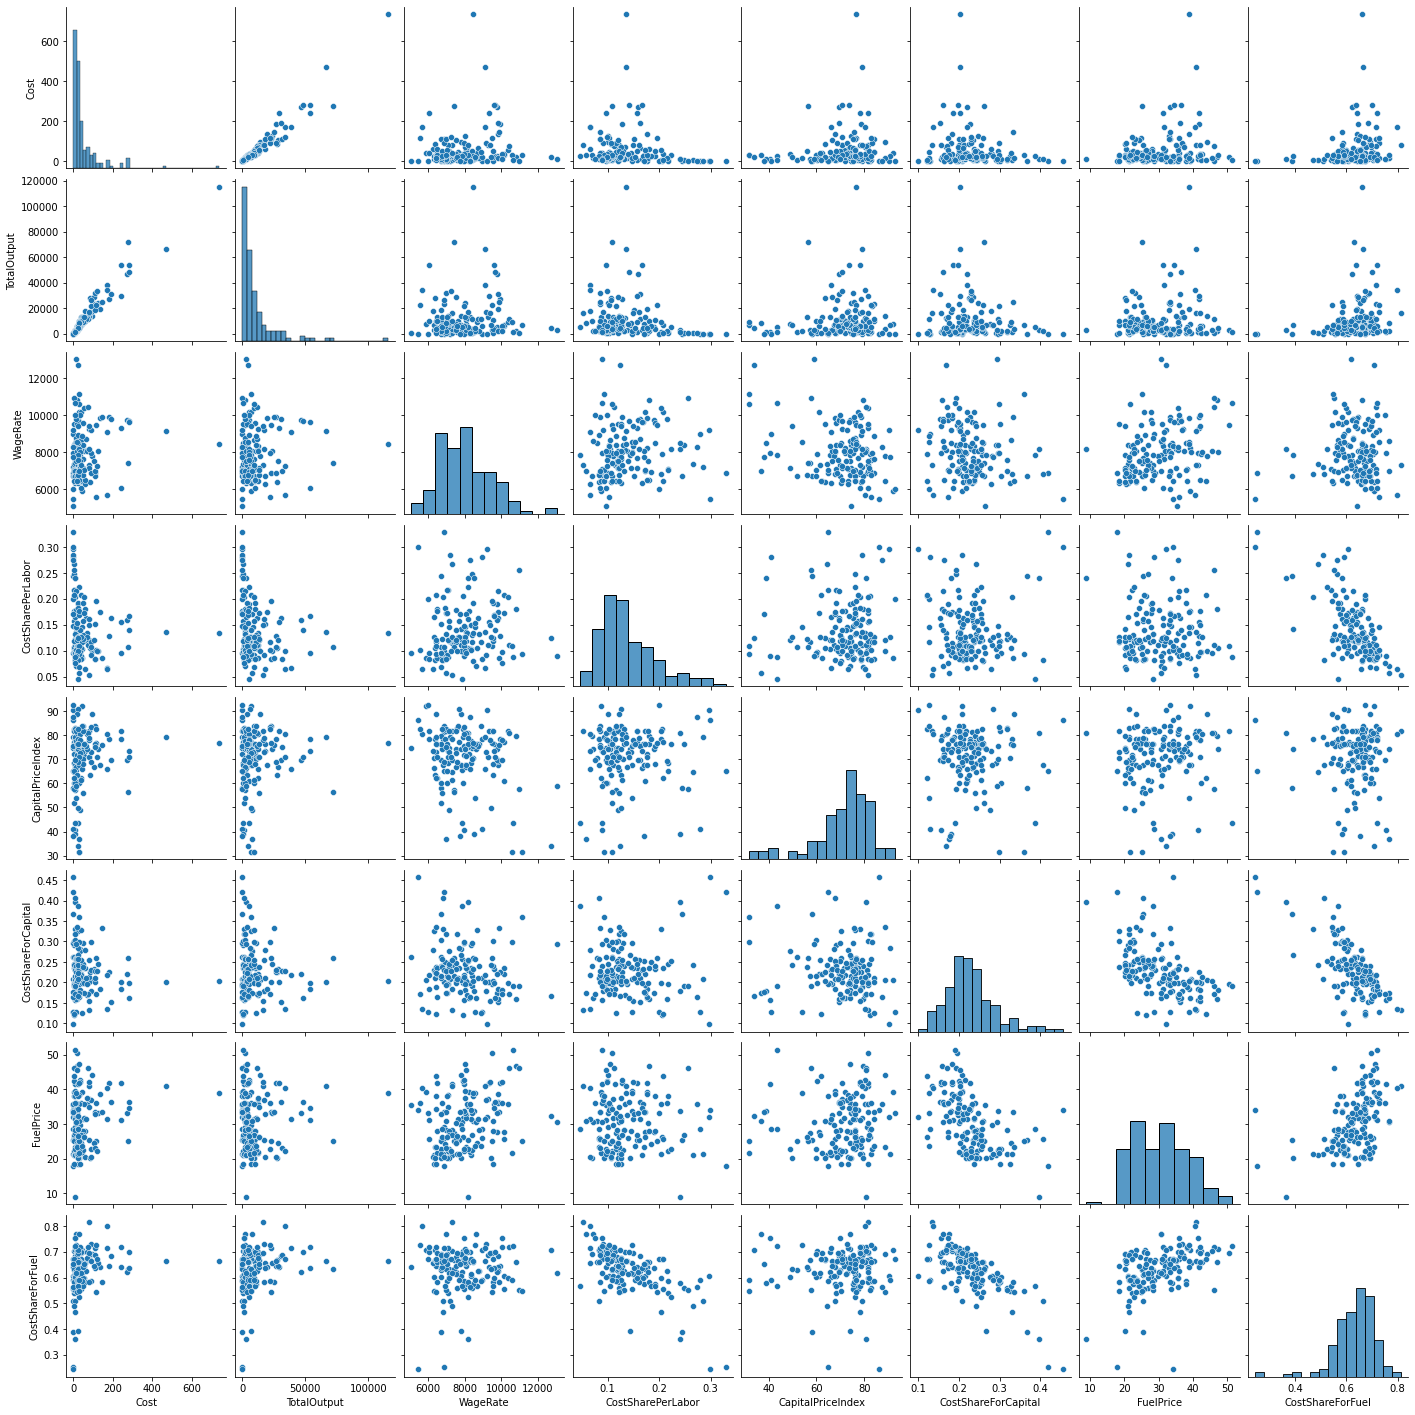

In [ ]:
sns.pairplot(elec)

#Normalize data set

In [ ]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()

#normalized data set
elec_scaled = s_scaler.fit_transform(elec[elec.columns[:]])
elec_scaled = pd.DataFrame(elec_scaled, columns=elec.columns[:])
elec_scaled.head()
elec_scaled.shape

(154, 8)

In [ ]:
elec_scaled.describe()

,Cost,TotalOutput,WageRate,CostSharePerLabor,CapitalPriceIndex,CostShareForCapital,FuelPrice,CostShareForFuel
count,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02,1.540000e+02
mean,-2.559280e-16,-2.119517e-16,-5.147398e-16,-4.325544e-17,1.470685e-16,5.118561e-17,-2.797185e-16,-1.208269e-15
std,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00,1.003263e+00
min,-6.139217e-01,-6.936250e-01,-2.120427e+00,-1.695226e+00,-3.280127e+00,-2.138498e+00,-2.742341e+00,-4.661031e+00
25%,-4.971844e-01,-5.626255e-01,-7.449964e-01,-7.094797e-01,-3.088943e-01,-5.739735e-01,-7.990775e-01,-5.026190e-01
50%,-3.241018e-01,-3.225988e-01,-8.049423e-02,-2.978746e-01,2.337975e-01,-1.424661e-01,2.309370e-03,1.560561e-01
75%,1.538595e-02,1.153588e-01,6.027200e-01,5.514330e-01,6.349419e-01,4.236284e-01,6.846185e-01,6.473630e-01
max,7.793630e+00,6.864722e+00,3.611006e+00,3.491273e+00,1.769663e+00,3.808186e+00,2.648993e+00,2.178873e+00


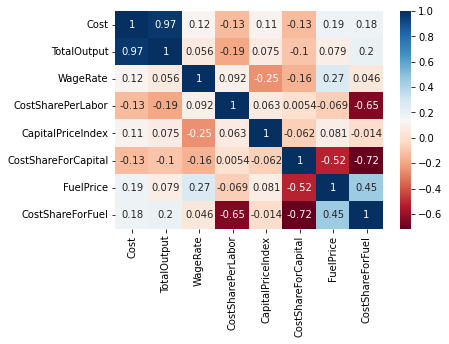

In [ ]:
#Pearson Correlation Matrix
elec_scaled.corr()
#use heatmap to display the correlation matrix 
sns.heatmap(elec_scaled.corr(),cmap='RdBu',annot=True)

#Split normalized data into training and test sets and examine regression assumptions

In [ ]:
#to start with, split into training and test sets
from sklearn.model_selection import train_test_split

X = elec_scaled.drop(['Cost'], axis = 1) 
Y = elec_scaled['Cost']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)#use 20% for test set

lm = LinearRegression()
lm.fit(X_train, Y_train)

#apply fitted multiple regression function to test set and compute residuals 
Y_pred = lm.predict(X_test)
Y_resid = Y_test - Y_pred

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


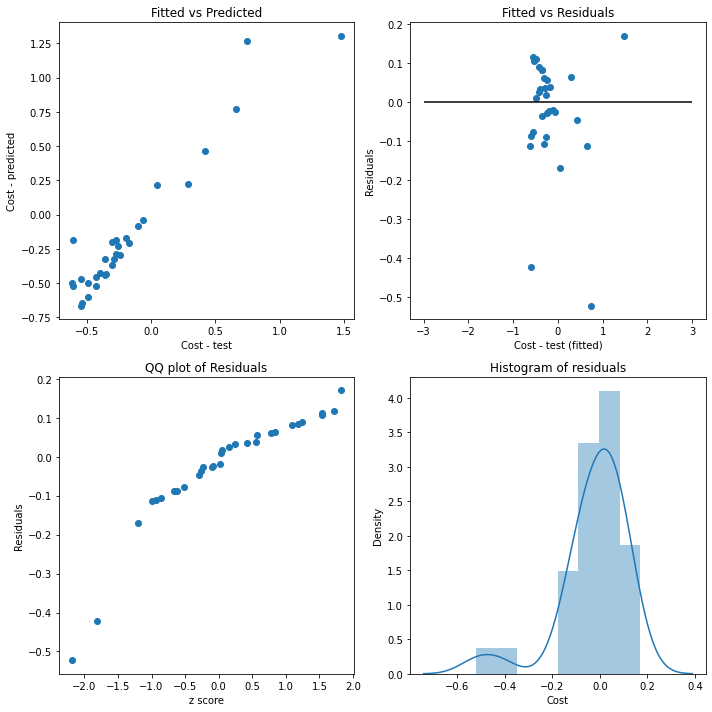

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
# plt.tight_layout()

plt1 = axs[0][0].scatter(x=Y_test, y=Y_pred)
axs[0][0].set_title('Fitted vs Predicted')
axs[0][0].set_xlabel('Cost - test')
axs[0][0].set_ylabel('Cost - predicted')

plt2 = axs[0][1].scatter(x=Y_test, y=Y_resid)
axs[0][1].hlines(0, xmin=-3, xmax=3)
axs[0][1].set_title('Fitted vs Residuals')
axs[0][1].set_xlabel('Cost - test (fitted)')
axs[0][1].set_ylabel('Residuals')

from numpy import random
axs[1][0].scatter(x=sorted(random.randn(len(Y_resid))), 
                  y=sorted(Y_resid))
axs[1][0].set_title('QQ plot of Residuals')
axs[1][0].set_xlabel('z score')
axs[1][0].set_ylabel('Residuals')

sns.distplot(Y_resid, ax=axs[1][1])
axs[1][1].set_title('Histogram of residuals')
plt.tight_layout()

#Outliers
1. Boxplot
2. Cook's distance

{'boxes': [<matplotlib.lines.Line2D at 0x7f610570a390>],
 'caps': [<matplotlib.lines.Line2D at 0x7f610574f790>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f61056e9d50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f61056e9850>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f610570a410>,
  <matplotlib.lines.Line2D at 0x7f6105776190>]}

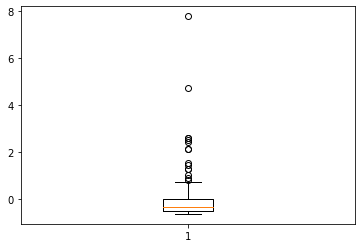

In [ ]:
#plot boxplot of repsonse variable 'cost'
plt.boxplot(Y)

In [ ]:
# X is predictors and Y is the response
X = elec_scaled.drop(['Cost'], axis = 1) 
Y = elec_scaled['Cost']

#fitted first-order regression function using all parameters
full_model = sm.OLS(Y,sm.add_constant(X)).fit()
cooks_distance = OLSInfluence(full_model).cooks_distance[0]

#sort cook's distance in a descending order
cooks_distance.sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


124    1.997121e+00
112    7.165117e-01
123    3.498544e-01
7      1.139269e-01
111    6.199645e-02
           ...     
128    1.102650e-06
104    5.855458e-07
94     3.270836e-07
108    2.070970e-07
139    1.670923e-07
Length: 154, dtype: float64

#Best Subset Model Selection
**Goal: to find the best subset model for each choice of p**

1.   Criterion used in this method including: R-squared, R-squared-adj, Cp, AIC, SBC and PRESS
2.   Create a table that displays the best values of each of these criterion
3. Plots of the best subets based on criteria for each p





Create a funtion for best subset method to obtain best subsets of predictor variable(s)

In [ ]:
def best_subsets(Y, X, P): #here the parameter 'P' is the number of predictors in a data set

    combs = [] #a list to store all choices of subsets for 1 <= p <= P (base model is exclusive)
    comb_nums = [] #a list to store the number of combinations of subsets for each choice of p

    for i in range(1,P+1):
      res = [list(x) for x in combinations(X.columns, i)]
      combs.append(res)
      comb_nums.append(len(list(combinations(X,i))))
    
    # create empty lists to store model selection criterion values 
    SSE =[]
    Rsquared = []
    Adj_Rsq = []
    AIC = []
    BIC = []
    Cp = []
    PRESS =[]
    
    #n is the number of observations 
    n=X.shape[0]
    lst = []# to store each choice of subsets 
    #linear regression function with intercept only
    constant = np.ones((n,1))
    model_0 = sm.OLS(Y,constant).fit()
    full_model = sm.OLS(Y,sm.add_constant(X)).fit()
    #create a data frame for the criterion values of base model 
    PRESS_0 = sum([resid ** 2 for resid in OLSInfluence(model_0).resid_press.tolist()])
    C_0 = (model_0.ssr)/(full_model.mse_resid) - n
    #p0 contains all the values of these criterion for linear model with intercept only
    
    
    for i in range(len(combs)): #i=0,1,...,6, when i=0, it means one x varaible is included, so p= i+1 
      for j in range(comb_nums[i]): 
        x = X[combs[i][j]]
        x = sm.add_constant(x)
        model = sm.OLS(Y,x).fit()
        full_model = sm.OLS(Y,sm.add_constant(X)).fit() # full model using intercept term and all predictors
        SSE.append(model.ssr)
        Rsquared.append(model.rsquared)
        Adj_Rsq.append(model.rsquared_adj)
        AIC.append(model.aic)
        BIC.append(model.bic)
        #for index i =0, comb[0] contains all the subset candidates for p=1, so p = i+1
        Cp.append((model.ssr/full_model.mse_resid)- (n-(2*(i+1))))
        PRESS.append(sum([number ** 2 for number in OLSInfluence(model).resid_press.tolist()])) #PRESS squared residual
        lst.append(combs[i][j])
    lst 
    df0 = pd.DataFrame({'Subsets':lst})
    data = list(zip(SSE, Rsquared, Adj_Rsq, AIC, BIC, Cp, PRESS))
    df1 = pd.DataFrame(data, columns = ['SSE', 'Rsquared', 'Adj_Rsq', 'AIC', 'SBC', 'Cp', 'PRESS'])
    df1 = pd.concat([df0, df1], sort=False, axis =1)
    
    
    variables_nums = []
    for idx in range(0, len(lst)):
      variables_nums.append(len(df1['Subsets'][idx]))
    variables_nums
    
    #add new column that shows the number of preditor variables for each row 
    df1 = pd.concat([pd.DataFrame({'P': variables_nums}), df1], sort=False, axis=1)
    
    SSE_min, SSE_best_subsets = [], []
    Rsquared_max, Rsquared_best_subsets = [], []
    Adj_Rsq_max, Adj_Rsq_best_subsets = [], []
    AIC_min, AIC_best_subsets = [], []
    SBC_min, SBC_best_subsets = [], []
    Cp_min, Cp_best_subsets = [], []
    PRESS_min, PRESS_best_subsets = [], []

    

    for idx in range(1, P+1): #choose the best values among each p for each criteria
      SSE_min.append(df1[df1['P']== idx]['SSE'].min())
      SSE_best_subsets.append(lst[df1[df1['P']== idx]['SSE'].idxmin()])
      Rsquared_max.append(df1[df1['P']== idx]['Rsquared'].max())
      Rsquared_best_subsets.append(lst[df1[df1['P']== idx]['Rsquared'].idxmax()])
      Adj_Rsq_max.append(df1[df1['P']== idx]['Adj_Rsq'].max())
      Adj_Rsq_best_subsets.append(lst[df1[df1['P']== idx]['Adj_Rsq'].idxmax()])
      AIC_min.append(df1[df1['P']== idx]['AIC'].min())
      AIC_best_subsets.append(lst[df1[df1['P']== idx]['AIC'].idxmin()])
      SBC_min.append(df1[df1['P']== idx]['SBC'].min())
      SBC_best_subsets.append(lst[df1[df1['P']== idx]['SBC'].idxmin()])
      Cp_min.append(df1[df1['P']== idx]['Cp'].min())
      Cp_best_subsets.append(lst[df1[df1['P']== idx]['Cp'].idxmin()])
      PRESS_min.append(df1[df1['P']== idx]['PRESS'].min())
      PRESS_best_subsets.append(lst[df1[df1['P']== idx]['PRESS'].idxmin()])
    
    predictors_nums = list(range(1,P+1))
    data_best_subsets = list(zip(predictors_nums, SSE_best_subsets, Rsquared_best_subsets, Adj_Rsq_best_subsets, AIC_best_subsets, 
                                 SBC_best_subsets, Cp_best_subsets, PRESS_best_subsets))
    best_subsets_variables = pd.DataFrame(data_best_subsets, columns = ['Number of Predictors','SSE', 'Rsquared', 'Adj_Rsq', 'AIC', 'SBC', 'Cp', 'PRESS'])
    

    parameter_nums = list(range(2, P+2)) 
    pd.DataFrame({'P': parameter_nums})
    data1 = list(zip(SSE_min, Rsquared_max, Adj_Rsq_max, AIC_min, SBC_min, Cp_min, PRESS_min))
    best_subsets_values = pd.DataFrame(data1, columns = ['SSE', 'Rsquared', 'Adj_Rsq', 'AIC', 'SBC', 'Cp', 'PRESS'])
    
    
    best_subsets_values = pd.concat([pd.DataFrame({'P': parameter_nums}), best_subsets_values], sort = False, axis = 1)
    new_row = pd.DataFrame({'P':1,'SSE': model_0.ssr, 'Rsquared': model_0.rsquared, 'Adj_Rsq': model_0.rsquared_adj,
                   'AIC': model_0.aic, 'SBC': model_0.bic, 'Cp':C_0, 'PRESS':PRESS_0}, index = [0])
    best_subsets_values = best_subsets_values.iloc[:0,].append([new_row,best_subsets_values.iloc[0:,]])
    best_subsets_values = best_subsets_values.reset_index(drop = True)
    

    #Part1 d)plot the best values of each criteria in the list 'criterion' for each choice of p
    criterion = ['Rsquared','Adj_Rsq','Cp','AIC','SBC','PRESS']

    for idx in range(len(criterion)):
      x_vals = best_subsets_values[criterion[idx]].tolist()
      y_vals = best_subsets_values['P'].tolist()
      plt.figure()
      plt.subplot(3,2,(idx + 1))
      plt.plot(y_vals, x_vals, linestyle = 'dashed', marker = 'D')
      plt.xlabel('$p$')
      plt.ylabel(criterion[idx])

    plt.show()


    return best_subsets_variables, best_subsets_values

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


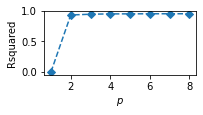

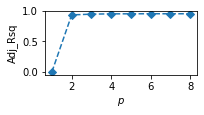

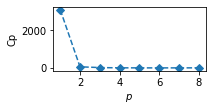

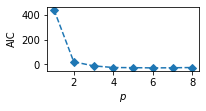

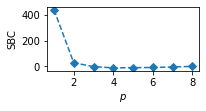

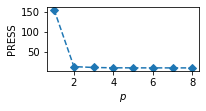

,P,SSE,Rsquared,Adj_Rsq,AIC,SBC,Cp,PRESS
0,1,154.000000,-2.220446e-16,-2.220446e-16,439.033068,442.070021,3088.377378,156.019651
1,2,10.092883,9.344618e-01,9.340306e-01,21.364268,27.438173,60.499581,12.598791
2,3,8.074084,9.475709e-01,9.468765e-01,-11.004077,-1.893219,19.994987,10.400926
3,4,7.307264,9.525502e-01,9.516012e-01,-24.371815,-12.224005,5.850052,9.574701
4,5,7.157394,9.535234e-01,9.522757e-01,-25.563147,-10.378384,4.694635,9.468752
5,6,6.982525,9.546589e-01,9.531271e-01,-27.372393,-9.150678,3.012871,9.387316
6,7,6.937149,9.549536e-01,9.531149e-01,-26.376429,-5.117761,4.057507,9.360583
7,8,6.934418,9.549713e-01,9.528124e-01,-24.437075,-0.141454,6.000000,9.364591


In [ ]:
#call function 'best_subsets'
P=7
n = X.shape[0] # the total number of observations for analysis
Y = elec_scaled['Cost'] # y response values data frame
X = elec_scaled.drop(['Cost'], axis =1)
electricity = best_subsets(Y, X, P)
electricity[1]

In [ ]:
#this data frame contains the best subset of predictor variables
electricity[0]

,Number of Predictors,SSE,Rsquared,Adj_Rsq,AIC,SBC,Cp,PRESS
0,1,[TotalOutput],[TotalOutput],[TotalOutput],[TotalOutput],[TotalOutput],[TotalOutput],[TotalOutput]
1,2,"[TotalOutput, FuelPrice]","[TotalOutput, FuelPrice]","[TotalOutput, FuelPrice]","[TotalOutput, FuelPrice]","[TotalOutput, FuelPrice]","[TotalOutput, FuelPrice]","[TotalOutput, FuelPrice]"
2,3,"[TotalOutput, FuelPrice, CostShareForFuel]","[TotalOutput, FuelPrice, CostShareForFuel]","[TotalOutput, FuelPrice, CostShareForFuel]","[TotalOutput, FuelPrice, CostShareForFuel]","[TotalOutput, FuelPrice, CostShareForFuel]","[TotalOutput, FuelPrice, CostShareForFuel]","[TotalOutput, FuelPrice, CostShareForFuel]"
3,4,"[TotalOutput, WageRate, FuelPrice, CostShareFo...","[TotalOutput, WageRate, FuelPrice, CostShareFo...","[TotalOutput, WageRate, FuelPrice, CostShareFo...","[TotalOutput, WageRate, FuelPrice, CostShareFo...","[TotalOutput, WageRate, FuelPrice, CostShareFo...","[TotalOutput, WageRate, FuelPrice, CostShareFo...","[TotalOutput, WageRate, FuelPrice, CostShareFo..."
4,5,"[TotalOutput, WageRate, CapitalPriceIndex, Fue...","[TotalOutput, WageRate, CapitalPriceIndex, Fue...","[TotalOutput, WageRate, CapitalPriceIndex, Fue...","[TotalOutput, WageRate, CapitalPriceIndex, Fue...","[TotalOutput, WageRate, CapitalPriceIndex, Fue...","[TotalOutput, WageRate, CapitalPriceIndex, Fue...","[TotalOutput, WageRate, CapitalPriceIndex, Fue..."
5,6,"[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap..."
6,7,"[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap...","[TotalOutput, WageRate, CostSharePerLabor, Cap..."


#Forward Stepwise Regression

In [ ]:
# create a function for forward stepwise regression method
def forward_stepwise(Y, X, alpha_to_enter, alpha_to_remove):

  best_variables = [] #a list to add chosen predicto(s) by forward stepwise regression method 
  X = X[X.columns] #predictors data frame

  while len(X.columns)>0:
    remaining_variables = X.drop(best_variables, axis=1) #remaining predictors' data frame 
    p_values = [] 
    for k in range (len(remaining_variables.columns)):
        x = sm.add_constant(X[best_variables+[remaining_variables.columns[k]]])
        model = sm.OLS(Y,x).fit()
        p_values.append(model.pvalues[-1]) #append candidate variables' p-values to the list 'p_values'
        #obtain the index of the variable with the smallest p-value
        index = p_values.index(min(p_values))
        p_values[index]  #this is the smallest p-val and we will compare it to a specified alpha_to_enter
        remaining_variables.columns[index] #the x variable corresponding to the smallest p-val
        
        #find the index/indices of variable(s) to remove from the list of best_variables if p-val of the variable exceeds alpha_to_enter
        model.pvalues[1:-1].tolist() #p values of current variables in best_variables 
        idx = [idx for idx, val in enumerate(model.pvalues[1:-1].tolist()) if val > alpha_to_remove]
    
        
    if p_values[index] < alpha_to_enter: 
        best_variables.append(remaining_variables.columns[index])
        variables_to_remove = [best_variables[index] for index in idx]
        best_variables = [variables for variables in best_variables if variables not in variables_to_remove]
        
    else:
        break
  best_variables
  
  return best_variables    

Call function 'forward_stepwise' to find the subset for 'Electricity' data set when the two parameters alpha_to enter and alpha_to_remove 0.1 and 0.15 respectively.

In [ ]:
#predictor variables data frame
X = elec_scaled.drop(['Cost'], axis =1)

#the response variable 'cost' data frame
Y = elec_scaled['Cost']

#another two parameters in 'forward_stepwise' function
alpha_to_enter = 0.1
alpha_to_remove = 0.15

#call function 'forward stepwise'
forward_stepwise(Y,X,alpha_to_enter, alpha_to_remove)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['TotalOutput',
 'FuelPrice',
 'CostShareForFuel',
 'WageRate',
 'CapitalPriceIndex']

**By forward stepwise regression method, when alpha to enter is set as 0.1, the predictors to enter the linear regression are: 'TotalOuput', 'FuelPrice' and 'CostShareForFuel', 'WageRate' and 'CapitalPiceIndex '**

Call function 'forward_stepwise' to find the subset for 'Electricity' data set when the two parameters alpha_to enter and alpha_to_remove 0.01 and 0.15 respectively.

In [ ]:
#predictor variables data frame
X = elec_scaled.drop(['Cost'], axis =1)

#the response variable 'cost' data frame
Y = elec_scaled['Cost']

#another two parameters in 'forward_stepwise' function
alpha_to_enter = 0.01
alpha_to_remove = 0.15

#call function 'forward stepwise'
forward_stepwise(Y,X,alpha_to_enter, alpha_to_remove)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['TotalOutput', 'FuelPrice', 'CostShareForFuel']

**By forward stepwise regression method, when alpha to enter is set as 0.01, the predictors to enter the linear regression are: 'TotalOuput', 'FuelPrice' and 'CostShareForFuel', 'WageRate' and 'CapitalPiceIndex '**

#Cross Validation - Predict final model performance

Predict the performance of final model with best subset of predictors: 'TotalOutput', 'FuelPrice' and 'CostShareForFuel' by using two scoring criterion: 'coefficient of determination' and 'explained_variance'. These two scores are easy to interpret and compare.

In [ ]:
from sklearn.model_selection import cross_val_score,KFold
lm = LinearRegression()

#final best subsets of predictors
X = elec_scaled[['TotalOutput','FuelPrice','CostShareForFuel']]
Y = elec_scaled['Cost']

#chose k fold to be 5
kf=KFold(n_splits=5, random_state=1, shuffle=True)
#chose the scoring 'explianed variance', of which the best score is 1
score=cross_val_score(lm,X,Y,scoring='explained_variance',cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Cross Validation Scores are [0.83889935 0.95215022 0.92324257 0.92278656 0.89134996]
Average Cross Validation score :0.9056857300934806


In [ ]:
from sklearn.model_selection import cross_val_score,KFold
lm = LinearRegression()

X = elec_scaled[['TotalOutput','FuelPrice','CostShareForFuel']]
Y = elec_scaled['Cost']

#chose k fold to be 5
kf=KFold(n_splits=5, random_state=1, shuffle=True)
score=cross_val_score(lm,X,Y,scoring='r2',cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))#returns negative MSE score

Cross Validation Scores are [0.83068986 0.94802282 0.92320872 0.92247384 0.88015094]
Average Cross Validation score :0.9009092362255586


Predict the performance of final model with best subset of predictors obtained using alpha to enter 0.1: 'TotalOutput', 'FuelPrice' and 'CostShareForFuel', 'WageRate' and 'CapitalPriceIndex' by using two scoring criterion: 'coefficient of determination' and 'explained_variance'

In [ ]:
from sklearn.model_selection import cross_val_score,KFold
lm = LinearRegression()
#the best subsets including five predictors
X = elec_scaled[['TotalOutput','FuelPrice','CostShareForFuel','WageRate', 'CapitalPriceIndex']]
Y = elec_scaled['Cost']

#chose k fold to be 5
kf=KFold(n_splits=5, random_state=1, shuffle=True)
score=cross_val_score(lm,X,Y,scoring='explained_variance',cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Cross Validation Scores are [0.82267781 0.95403876 0.92703721 0.92590706 0.89459541]
Average Cross Validation score :0.9048512501149653


In [ ]:
from sklearn.model_selection import cross_val_score,KFold
lm = LinearRegression()
#the best subsets including five predictors
X = elec_scaled[['TotalOutput','FuelPrice','CostShareForFuel','WageRate', 'CapitalPriceIndex']]
Y = elec_scaled['Cost']

#chose k fold to be 5
kf=KFold(n_splits=5, random_state=1, shuffle=True)
score=cross_val_score(lm,X,Y,scoring='r2',cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Cross Validation Scores are [0.81765413 0.95046821 0.927027   0.92589509 0.88549574]
Average Cross Validation score :0.901308032488432
